In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


plt.style.use("../science.mplstyle")

from helpers.physics_functions import bkg_fit_cubic, bkg_fit_quintic, bkg_fit_septic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio
from helpers.evaluation import get_median_percentiles

In [2]:
pickle_save_dir_prefix = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/pickles/single_3"
train_samesign = False

working_dir = f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/lowmass_scan/"


if train_samesign:
    train_data_id = "_samesign"
else:
    train_data_id = ""

# train on opp sign means alt test set is samesign
if train_data_id == "": 
    alt_test_data_id = "_samesign"
    train_data_id_title = "_oppsign"
elif train_data_id == "_samesign": 
    alt_test_data_id = ""
    train_data_id_title = "_samesign"
    


In [3]:
# read in the window_definitions


with open(f"{working_dir}/processed_data/window_definitions", "rb") as infile:
    window_definitions = pickle.load(infile)
    
num_windows = len(window_definitions["SB_left"])      
print(num_windows)

193


# Load in the BDT results for one window

In [4]:
num_bootstraps = 1
n_folds = 5

window_index_to_plot = 0
pseudo_e_to_plot = 0
fit_type = "quintic"

SB_left = window_definitions["SB_left"][window_index_to_plot]
SR_left = window_definitions["SR_left"][window_index_to_plot]
SR_right = window_definitions["SR_right"][window_index_to_plot]
SB_right = window_definitions["SB_right"][window_index_to_plot]

with open(f"{pickle_save_dir_prefix}_{window_index_to_plot}{train_data_id_title}/all_test_data_splits", "rb") as ifile:
    all_test_data_splits = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{window_index_to_plot}{train_data_id_title}/all_alt_data_splits", "rb") as ifile:
    all_alt_data_splits = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{window_index_to_plot}{train_data_id_title}/all_scores_splits", "rb") as ifile:
    all_scores_splits = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{window_index_to_plot}{train_data_id_title}/all_alt_scores_splits", "rb") as ifile:
    all_alt_scores_splits = pickle.load(ifile)

    
with open(f"{working_dir}/processed_data/mass_scaler_{window_index_to_plot}", "rb") as ifile:
    scaler = pickle.load(ifile)

## Carry out the scan

In [5]:
# generate the bins


detector_resolution = 0.01
start_mass = 0.3

current_mass = start_mass
all_bins = [start_mass]


while current_mass < 20:
    loc_bin_width = current_mass*detector_resolution
    current_mass += loc_bin_width
    all_bins.append(current_mass)
    

On window index 0...
On window index 1...


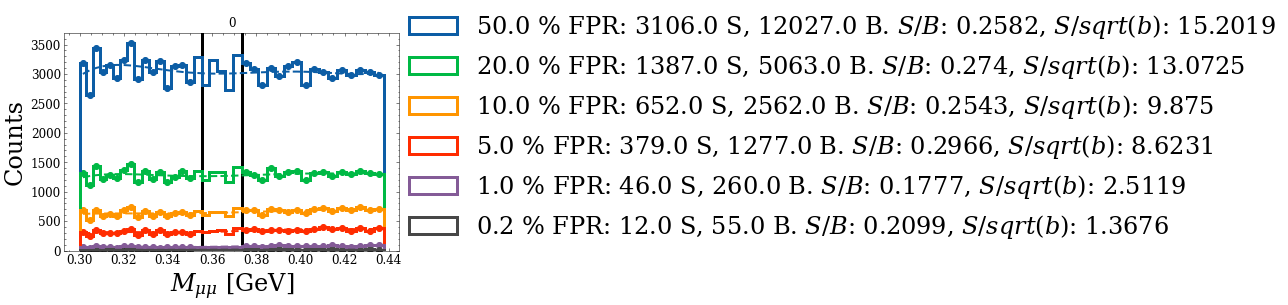

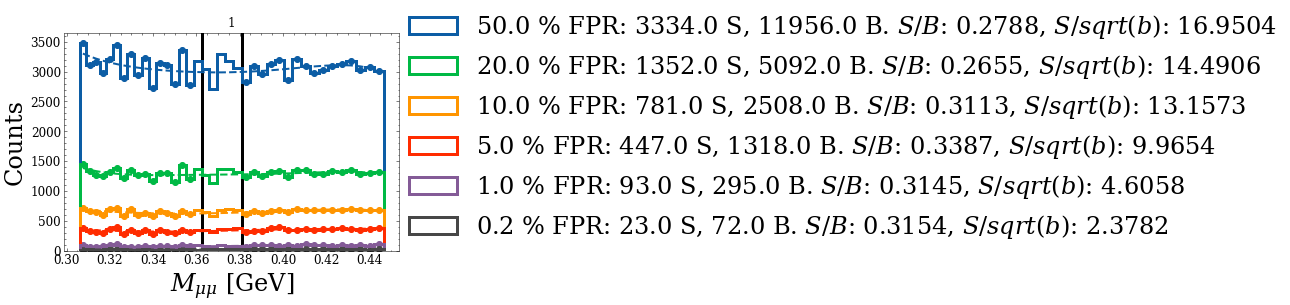

In [10]:
num_bootstraps = 1
n_folds = 5
pseudo_e_to_plot = 0
fit_type = "quintic"
                  
if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic": fit_function = bkg_fit_quintic
elif fit_type == "septic": fit_function = bkg_fit_septic

SR_centers = []

#fprs = [1, 0.5, 0.25, 0.1,0.05, 0.02]

fprs = [0.5, 0.2, 0.1,0.05, 0.01, 0.002]


fpr_thresholds = {x:[] for x in fprs}

for window_index in range(2):
    
    print(f"On window index {window_index}...")
    
    # load in the window definitions
    SB_left = window_definitions["SB_left"][window_index]
    SR_left = window_definitions["SR_left"][window_index]
    SR_right = window_definitions["SR_right"][window_index]
    SB_right = window_definitions["SB_right"][window_index]
    
    SR_centers.append(0.5*(SR_left + SR_right))

    with open(f"{pickle_save_dir_prefix}_{window_index}{train_data_id_title}/all_test_data_splits", "rb") as ifile:
        all_test_data_splits = pickle.load(ifile)
    with open(f"{pickle_save_dir_prefix}_{window_index}{train_data_id_title}/all_alt_data_splits", "rb") as ifile:
        all_alt_data_splits = pickle.load(ifile)
    with open(f"{pickle_save_dir_prefix}_{window_index}{train_data_id_title}/all_scores_splits", "rb") as ifile:
        all_scores_splits = pickle.load(ifile)
    with open(f"{pickle_save_dir_prefix}_{window_index}{train_data_id_title}/all_alt_scores_splits", "rb") as ifile:
        all_alt_scores_splits = pickle.load(ifile)
        
    # choose what to plot
    if train_samesign:
        data_dict_by_fold = all_alt_data_splits[pseudo_e_to_plot]["alt"]
        scores_dict_by_fold = all_alt_scores_splits[pseudo_e_to_plot]["alt"]
    else:
        data_dict_by_fold = all_test_data_splits[pseudo_e_to_plot]
        scores_dict_by_fold = all_scores_splits[pseudo_e_to_plot]

    # load in the mass scalar
    with open(f"{working_dir}/processed_data/mass_scaler_{window_index}", "rb") as ifile:
        scaler = pickle.load(ifile)
        
    # determine score cutoffs for each pseudoexperiments

    
    score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_bootstraps)}
    for pseudo_e in range(num_bootstraps):
        for i_fold in range(n_folds):
            loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
            for threshold in fpr_thresholds.keys():
                loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
                score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff

    # CARRY OUT THE CURVE FITTING
    
    #plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = 8)
    SB_left_index = all_bins.index(SB_left)
    SR_left_index = all_bins.index(SR_left)
    SR_right_index = all_bins.index(SR_right)
    SB_right_index = all_bins.index(SB_right)
    
    plot_bins_left = all_bins[SB_left_index:SR_left_index]
    plot_bins_SR = all_bins[SR_left_index:SR_right_index]
    plot_bins_right = all_bins[SR_right_index:SB_right_index]
    
    plot_bins_all = all_bins[SB_left_index:SB_right_index]
    
    plot_centers_left = [np.sqrt(plot_bins_left[i]*plot_bins_left[i+1]) for i in range(len(plot_bins_left)-1)]
    plot_centers_SR = np.array([np.sqrt(plot_bins_SR[i]*plot_bins_SR[i+1]) for i in range(len(plot_bins_SR)-1)])
    plot_centers_right = [np.sqrt(plot_bins_right[i]*plot_bins_right[i+1]) for i in range(len(plot_bins_right)-1)]
    
    
    plot_centers_all = np.concatenate([plot_centers_left, plot_centers_SR, plot_centers_right])
    plot_centers_SB = np.concatenate([plot_centers_left, plot_centers_right])
        
        
    plt.figure(figsize = (6, 4))
    
        
    for t, threshold in enumerate(fpr_thresholds.keys()):

        filtered_masses = []

        for i_fold in range(n_folds):
            loc_true_masses = scaler.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            loc_scores = scores_dict_by_fold[i_fold]
            loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs[pseudo_e_to_plot][i_fold][threshold], plot_bins_left, plot_bins_right, plot_bins_SR)
            filtered_masses.append(loc_filtered_masses)

        filtered_masses = np.concatenate(filtered_masses)

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    

        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)
        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sqrt(np.sum(y_err**2))
        
        S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
        significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
        label_string = f"{round(100*threshold, 2)} % FPR: {round(num_S_expected_in_SR, 0)} S, {round(num_B_expected_in_SR, 0)} B. $S/B$: {round(S_over_B,4)}, $S/sqrt(b)$: {round(significance,4)}"


        fpr_thresholds[threshold].append(significance)
        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


    plt.legend(loc = (1, 0), fontsize = 24)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
    plt.ylabel("Counts", fontsize = 24)
    
    plt.title(window_index)

    




In [ ]:
# load in the mass data

path_to_compiled_data = f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/compiled_data/lowmass"
    
run_jet = False
if run_jet:
    codes_list = ["DATA_jet"]
    sim_id = "DATA_jet" # should probably rename this to data_id
else:
    codes_list = ["DATA_nojet"]
    sim_id = "DATA_nojet" # should probably rename this to data_id
signal_id = ""
    
uncut_data, uncut_data_samesign = {code:{} for code in codes_list},  {code:{} for code in codes_list}

for code in codes_list:
    with open(f"{path_to_compiled_data}/{code}", "rb") as ifile:
        tmp_dict = pickle.load(ifile)
        for key in tmp_dict.keys():
            if "samesign" in key:
                uncut_data_samesign[code][key[:-9]] = tmp_dict[key]
            else:
                uncut_data[code][key] = tmp_dict[key]
        
    
    print(code, "opp sign",  uncut_data[code][list(uncut_data[code].keys())[0]].shape)
    print(code, "same sign", uncut_data_samesign[code][list(uncut_data[code].keys())[0]].shape)

In [ ]:
plt.figure(figsize = (16,4))
ax1 = plt.gca()

ax2 = ax1.twinx()

for f in fprs:

    ax1.plot(SR_centers, fpr_thresholds[f], label = f"{f*100}% FPR", lw = 3)


ax2.hist(uncut_data["DATA_nojet"]["dimu_mass"], bins = all_bins, density = True, alpha = 0.3)
ax2.set_yticks([])

plt.xscale("log")
plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
ax1.set_ylabel("Significance", fontsize = 24)
ax1.set_ylim([-5, 8])   
ax1.legend(fontsize=12)

ax1.set_xlabel("$M$ [GeV]")

ax1.axhline(5, linestyle = "dashed", color = "k")

plt.axvline(0.547, lw = 3, color = "k", alpha=0.2) # eta
plt.axvline(0.774, lw = 3, color = "k", alpha=0.2) # rho
plt.axvline(1.019, lw = 3, color = "k", alpha=0.2) # phi

plt.show()